# **Fit GLM-HMM to dmdm data**
---
We then fit GLM-HMM to the dataset.

## **HPC setting**
Ashwood's original script is written in python scirpts. Here, we rewrite it in Jupyter to make it more user-friendly to run on HPC with `dask`. [This](https://github.com/pierreglaser/hpc-tutorial/tree/main) is very useful resource to get familiar with `dask`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# allocate the computing resources
from dask_jobqueue import SLURMCluster
from distributed import Client
from joblib import Memory, Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits

cluster = SLURMCluster(
    workers=0,      # create the workers "lazily" (upon cluster.scal)
    memory='32g',   # amount of RAM per worker
    processes=1,    # number of execution units per worker (threads and processes)
    cores=1,        # among those execution units, number of processes
    # A lazy trick to avoid matplotlib crash with parallel plotting
    worker_extra_args=["--resources GPU=2"], # the only way to add GPUs
    local_directory='/nfs/nhome/live/skuroda/jobs', # set your path to save log
    log_directory='/nfs/nhome/live/skuroda/jobs' # set your path to save log
)   

memory = Memory('/nfs/nhome/live/skuroda/joblib-cache') # set your path

cluster.scale(10)
client = Client(cluster)
print(client.dashboard_link)

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/

http://192.168.234.51:8787/status


## **GLM fitting**
---

In [3]:
# ------- load modules -------
import autograd.numpy as np
import autograd.numpy.random as npr
from glm_utils import get_file_dir, load_session_fold_lookup, load_data, fit_glm, \
    plot_input_vectors, load_animal_list
from functools import partial
from collections import OrderedDict

In [4]:
# ------- setup variables -------
dname = 'dataAllMice'
C = 4  # number of output types/categories. Hit/FA/Miss/Abort
nested_outcome = OrderedDict() # define nested structure for behavioral outcomes
nested_outcome["Baseline"] = [2, 3]
nested_outcome["Change"] = [0, 1]

N_initializations = 10
num_folds = 5
labels_for_plot = ['CSize', 'COnset', 
                   'PrevMiss?', 'PrevHit?', 'PrevFA?', 'PrevAbort?',
                   'bias']
npr.seed(65)  # set seed in case of randomization

## **Fit GLM to all animals**
---

In [5]:
# ------- setup path and load data -------
data_dir =  get_file_dir().parents[2] / "data" / "dmdm" / dname / 'data_for_cluster'
# Create directory for results:
results_dir = get_file_dir().parents[2] / "results" / "dmdm_global_fit" / dname
results_dir.mkdir(parents=True, exist_ok=True)

animal_file = data_dir / 'all_animals_concat.npz'
inpt, y, session, rt, stimT = load_data(animal_file)
session_fold_lookup_table = load_session_fold_lookup(
    data_dir / 'all_animals_concat_session_fold_lookup.npz')

In [6]:
def fit_GLM(inpt, y, session, session_fold_lookup_table, labels_for_plot, nested_outcome, fold):
    # Subset to relevant covariates for covar set of interest:
    y = y.astype('int')
    figure_directory = results_dir / "GLM" / ("fold_" + str(fold)) 
    figure_directory.mkdir(parents=True, exist_ok=True)

    # Subset to sessions of interest for fold
    sessions_to_keep = session_fold_lookup_table[np.where(
        session_fold_lookup_table[:, 1] != fold), 0]
    idx_this_fold = [
        str(sess) in sessions_to_keep and y[id, 0] != -1
        for id, sess in enumerate(session)
    ]
    this_inpt, this_y, this_session = inpt[idx_this_fold, :], y[
        idx_this_fold, :], session[idx_this_fold]
    assert len(
        np.unique(this_y)
    ) == 4, "choice vector should only include 4 possible values"
    train_size = this_inpt.shape[0]

    M = this_inpt.shape[1]
    loglikelihood_train_vector = []

    for iter in range(N_initializations):  # GLM fitting should be
        # independent of initialization, so fitting multiple
        # initializations is a good way to check that everything is
        # working correctly
        loglikelihood_train, recovered_weights = fit_glm([this_inpt],
                                                         [this_y], 
                                                         M, 
                                                         C,
                                                         nested_outcome)
        # weights_for_plotting = append_zeros(recovered_weights)
        plot_input_vectors(recovered_weights,
                           figure_directory,
                           title="GLM fit; Final LL = " +
                           str(loglikelihood_train),
                           save_title='init' + str(iter),
                           labels_for_plot=labels_for_plot)
        loglikelihood_train_vector.append(loglikelihood_train)
        np.savez(
            figure_directory / ('variables_of_interest_iter_' + str(iter) + '.npz'), 
            loglikelihood_train, recovered_weights)
        

fit_GLM_eachfold = partial(fit_GLM, inpt, y, session, session_fold_lookup_table, labels_for_plot, nested_outcome)        
fit_GLM_eachfold_cached = memory.cache(fit_GLM_eachfold)

In [7]:
%%time
with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=60):
        Parallel(verbose=100)(delayed(fit_GLM_eachfold_cached)(fold) for fold in range(num_folds))

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.9s remaining:   38.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.8s finished
CPU times: user 4.19 s, sys: 216 ms, total: 4.41 s
Wall time: 1min


/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gon

[[[ 2.43082942e+01  1.05020899e+00  5.02705370e-01 -3.96309439e-01
   -1.69501027e+00 -9.21383441e-01 -1.97509085e+00]
  [ 2.52312557e+01  5.88901304e-01 -5.23101424e-01  2.62767941e-02
   -8.98208488e-01 -6.14676465e-01 -1.69723688e+00]
  [-2.36734407e+01 -8.04378705e-01  4.28208817e-01  1.66214464e+00
    1.13826672e+00  8.36993052e-01  8.97323554e-01]
  [-2.13504605e+01 -1.05511922e+00  2.13002618e-02  6.56443396e-01
   -4.80229370e-01  1.44895793e+00  1.62674531e+00]]]


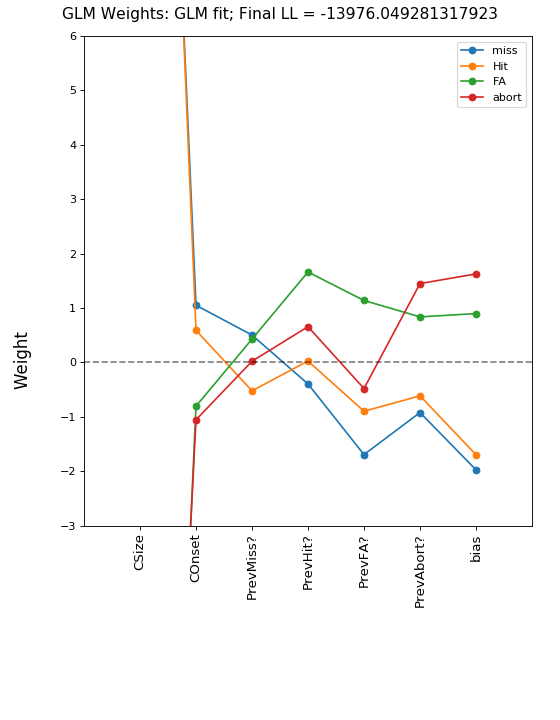

In [12]:
# Plot some results
from IPython.display import Image
example_npz_loc = str(results_dir / "GLM" / "fold_4" / 'variables_of_interest_iter_9.npz')
example_npz = np.load(example_npz_loc)
example_img_loc = str(results_dir / "GLM" / "fold_4" / 'glm_weights_init9.png')
print(example_npz['arr_1'])
Image(filename=example_img_loc) 

## **Fit GLM to each animal separately**
---

In [5]:
# ------- setup path and load data -------
data_2_dir =  get_file_dir().parents[2] / "data" / "dmdm" / dname / 'data_for_cluster' / "data_by_animal"
# Create directory for results:
results_2_dir = get_file_dir().parents[2] / "results" / "dmdm_individual_fit" / dname
results_2_dir.mkdir(parents=True, exist_ok=True)

animal_list = load_animal_list(data_2_dir / 'animal_list.npz')

In [6]:
def fit_GLM_separately(data_2_dir, results_2_dir, labels_for_plot, nested_outcome, num_folds, animal):
    # Fit GLM to data from single animal:
    animal_file = data_2_dir / (animal + '_processed.npz')
    session_fold_lookup_table = load_session_fold_lookup(
        data_2_dir / (animal + '_session_fold_lookup.npz'))
    this_results_dir = results_2_dir / animal

    # Load data
    print(str(animal_file))
    inpt, y, session, rt, stimT = load_data(animal_file)
    y = y.astype('int')


    for fold in range(num_folds):
        figure_directory = this_results_dir / "GLM" / ("fold_" + str(fold)) 
        figure_directory.mkdir(parents=True, exist_ok=True)

        # Subset to sessions of interest for fold
        sessions_to_keep = session_fold_lookup_table[np.where(
            session_fold_lookup_table[:, 1] != fold), 0]
        idx_this_fold = [
            str(sess) in sessions_to_keep and y[id, 0] != -1
            for id, sess in enumerate(session)
        ]
        this_inpt, this_y, this_session = inpt[idx_this_fold, :], \
                                            y[idx_this_fold, :], \
                                            session[idx_this_fold]
        assert len(
            np.unique(this_y)
        ) == 4, "choice vector should only include 4 possible values"
        train_size = this_inpt.shape[0]

        M = this_inpt.shape[1]
        loglikelihood_train_vector = []

        for iter in range(N_initializations):
            loglikelihood_train, recovered_weights = fit_glm([this_inpt],
                                                            [this_y], 
                                                            M, 
                                                            C,
                                                            nested_outcome)
            plot_input_vectors(recovered_weights,
                                figure_directory,
                                title="GLM fit; Final LL = " +
                                str(loglikelihood_train),
                                save_title='init' + str(iter),
                                labels_for_plot=labels_for_plot)
            loglikelihood_train_vector.append(loglikelihood_train)
            np.savez(
                figure_directory / ('variables_of_interest_iter_' + str(iter) + '.npz'),
                loglikelihood_train, recovered_weights)
            
fit_GLM_separately_eachanimal = partial(fit_GLM_separately, data_2_dir, results_2_dir, labels_for_plot, nested_outcome, num_folds)     
fit_GLM_separately_eachanimal_cached = memory.cache(fit_GLM_separately_eachanimal)


In [7]:
%%time
with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=60):
        Parallel(verbose=100)(delayed(fit_GLM_separately_eachanimal_cached)(animal) for animal in animal_list)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   6 | elapsed:   53.4s remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  1.8min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.8min remaining:   54.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min finished
CPU times: user 6.76 s, sys: 1.03 s, total: 7.79 s
Wall time: 1min 56s


[[[ 26.50817587   2.04764492   0.76747183  -0.32088249  -0.7410588
    -1.45213548  -2.52504852]
  [ 29.98543509   1.4938224   -0.22269062  -0.32271204  -0.84910361
    -0.8739255   -1.7959055 ]
  [-23.32354345   0.22851751   0.83716614   1.06792175   0.88180337
     0.77301953   1.53354816]
  [-37.72089713  -0.70799914   0.29814214   0.60219779   0.39182273
     1.51472287   1.05153583]]]


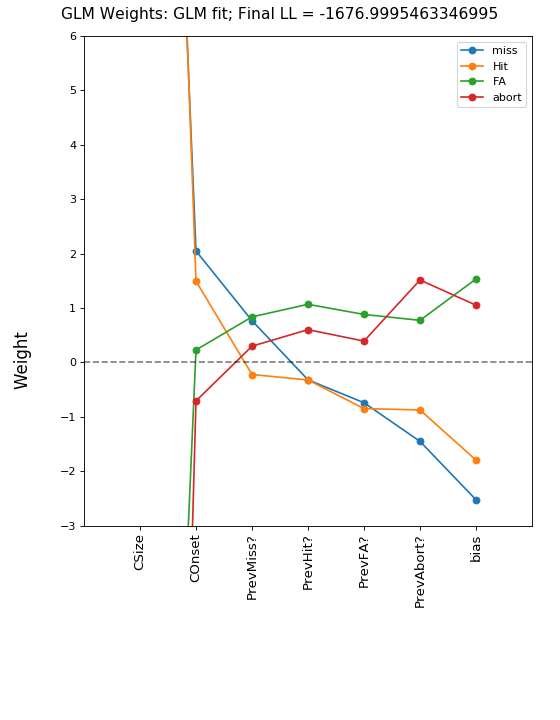

In [8]:
# Plot some results
from IPython.display import Image
example_npz_loc = str(results_2_dir / 'x1119408' / "GLM" / "fold_4" / 'variables_of_interest_iter_9.npz')
example_npz = np.load(example_npz_loc)
example_img_loc = str(results_2_dir / 'x1119408' / "GLM" / "fold_4" / 'glm_weights_init9.png')
print(example_npz['arr_1'])
Image(filename=example_img_loc) 

In [9]:
# Once finished, shut down the cluster and the client
cluster.close()
client.close()

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gon